# Group 70: Project Proposal
## Predicting Cancer Mortality Rates Through Varying Demographic Data

### Introduction
Cancer is one of the leading causes of death in the developed world. Therefore, the capability to predict cancer mortality rates from demographic data could prove to be an invaluable tool in understanding and combating cancer mortality. Using a dataset imported from data.world that aggregates data from the American Community Survey, clinicaltrails.gov (a public clinical trial database), and the National Cancer Institute, we hope to predict the cancer mortality rate of a county using demographic data. Our question is the following: given up to 5 predictors taken from demographic data in a certain county in the United States, what will be the cancer mortality rate of that county? The predictors were determined using the regsubsets() function in R, specified in the methodology, and their relevance was further supported by prior research (cited below) that demonstrates a significant relationship between the predictors and their implications on cancer mortality rates.

### Methodology

We start our analysis by installing and loading all necessary R packages required for our report.

In [3]:
#Loading libraries

install.packages(c("leaps"))

library(tidyverse) # to perform operations on the data set
library(repr) # to set graph plot size and performing some operations on data set
library(tidymodels)
library(leaps) # to use regsubsets on dataframe
library(cowplot)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks st

### Reading data from URL
To prepare our data for analysis, we started out with downloading the dataset from the web and publishing the data on our group GitHub. We then pulled the dataset and read it on Jupyter using a URL.

We also set a seed value to ensure that our code is reproducible.

In [4]:
# Reading the training data set from the Web into R
url <- "https://raw.githubusercontent.com/mimilht/dsci100-proj-group70/main/cancer_reg.csv"
cancer <- read_csv(url) # read csv file from url
head(cancer)

set.seed(100) #setting seed value to ensure results are reproducible

Rows: 3047 Columns: 34
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): binnedInc, Geography
dbl (32): avgAnnCount, avgDeathsPerYear, TARGET_deathRate, incidenceRate, me...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


avgAnnCount,avgDeathsPerYear,TARGET_deathRate,incidenceRate,medIncome,popEst2015,povertyPercent,studyPerCap,binnedInc,MedianAge,⋯,PctPrivateCoverageAlone,PctEmpPrivCoverage,PctPublicCoverage,PctPublicCoverageAlone,PctWhite,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1397,469,164.9,489.8,61898,260131,11.2,499.74820,"(61494.5, 125635]",39.3,⋯,NA,41.6,32.9,14.0,81.78053,2.5947283,4.8218571,1.8434785,52.85608,6.118831
173,70,161.3,411.6,48127,43269,18.6,23.11123,"(48021.6, 51046.4]",33.0,⋯,53.8,43.6,31.1,15.3,89.22851,0.9691025,2.2462326,3.7413515,45.37250,4.333096
102,50,174.7,349.7,49348,21026,14.6,47.56016,"(48021.6, 51046.4]",45.0,⋯,43.5,34.9,42.1,21.1,90.92219,0.7396734,0.4658982,2.7473583,54.44487,3.729488
427,202,194.8,430.4,44243,75882,17.1,342.63725,"(42724.4, 45201]",42.8,⋯,40.3,35.0,45.3,25.0,91.74469,0.7826260,1.1613587,1.3626432,51.02151,4.603841
57,26,144.4,350.1,49955,10321,12.5,0.00000,"(48021.6, 51046.4]",48.3,⋯,43.9,35.1,44.0,22.7,94.10402,0.2701920,0.6658304,0.4921355,54.02746,6.796657
428,152,176.0,505.4,52313,61023,15.6,180.25990,"(51046.4, 54545.6]",45.4,⋯,38.8,32.6,43.2,20.2,84.88263,1.6532052,1.5380566,3.3146354,51.22036,4.964476


### Cleaning and Wrangling Data into Tidydata Format

We start our data cleaning by checking how many NA observations are in each column. This step helps us decide which columns have too few data points to be useful in our prediction model.

To clean our data, we removed any column with less than 2800 non-NA values and non-numerical columns. We decided that using total deaths per capita, cancer cases per capita, and the number of cancer-related clinical trials to predict cancer mortality rates would be irrelevant to our report as they reflect a similar measure to our target/dependent variable — cancer mortality rate. Hence, we also removed these columns from our data set.

We then remove the missing data from our columns by removing the N/A fields.

In [6]:
cancer_data <- cancer |> filter(na.rm = TRUE)
colSums(!is.na(cancer)) #counting number of observations in our columns (excluding n/a)

# removing columns with <2800 observations and non-numerical values
cancer_filter <- cancer_data |> select(-PctPrivateCoverageAlone, 
                                       -PctSomeCol18_24, -Geography, -avgAnnCount,
                                      -avgDeathsPerYear, -incidenceRate, -studyPerCap, -binnedInc)
cancer_clean <- na.omit(cancer_filter) |> #removing na from our data
    rename(CancerMortRate = TARGET_deathRate,
          MedianIncome = medIncome,
          Population = popEst2015,
          PovertyRate = povertyPercent) # renaming columns to consistent format
head(cancer_clean)

avgAnnCount        avgDeathsPerYear        TARGET_deathRate 
                   3047                    3047                    3047 
          incidenceRate               medIncome              popEst2015 
                   3047                    3047                    3047 
         povertyPercent             studyPerCap               binnedInc 
                   3047                    3047                    3047 
              MedianAge           MedianAgeMale         MedianAgeFemale 
                   3047                    3047                    3047 
              Geography        AvgHouseholdSize          PercentMarried 
                   3047                    3047                    3047 
           PctNoHS18_24              PctHS18_24         PctSomeCol18_24 
                   3047                    3047                     762 
        PctBachDeg18_24            PctHS25_Over       PctBachDeg25_Over 
                   3047                    3047                    3047 
     PctEmployed16_Over    PctUnemployed16_Over      PctPrivateCoverage 
                   2895                    3047                    3047 
PctPrivateCoverageAlone      PctEmpPrivCoverage       PctPublicCoverage 
                   2438                    3047                    3047 
 PctPublicCoverageAlone                PctWhite                PctBlack 
                   3047                    3047                    3047 
               PctAsian            PctOtherRace    PctMarriedHouseholds 
                   3047                    3047                    3047 
              BirthRate 
                   3047

CancerMortRate,MedianIncome,Population,PovertyRate,MedianAge,MedianAgeMale,MedianAgeFemale,AvgHouseholdSize,PercentMarried,PctNoHS18_24,⋯,PctPrivateCoverage,PctEmpPrivCoverage,PctPublicCoverage,PctPublicCoverageAlone,PctWhite,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
164.9,61898,260131,11.2,39.3,36.9,41.7,2.54,52.5,11.5,⋯,75.1,41.6,32.9,14.0,81.78053,2.5947283,4.8218571,1.8434785,52.85608,6.118831
161.3,48127,43269,18.6,33.0,32.2,33.7,2.34,44.5,6.1,⋯,70.2,43.6,31.1,15.3,89.22851,0.9691025,2.2462326,3.7413515,45.37250,4.333096
174.7,49348,21026,14.6,45.0,44.0,45.8,2.62,54.2,24.0,⋯,63.7,34.9,42.1,21.1,90.92219,0.7396734,0.4658982,2.7473583,54.44487,3.729488
194.8,44243,75882,17.1,42.8,42.2,43.4,2.52,52.7,20.2,⋯,58.4,35.0,45.3,25.0,91.74469,0.7826260,1.1613587,1.3626432,51.02151,4.603841
144.4,49955,10321,12.5,48.3,47.8,48.9,2.34,57.8,14.9,⋯,61.6,35.1,44.0,22.7,94.10402,0.2701920,0.6658304,0.4921355,54.02746,6.796657
176.0,52313,61023,15.6,45.4,43.5,48.0,2.58,50.4,29.9,⋯,60.0,32.6,43.2,20.2,84.88263,1.6532052,1.5380566,3.3146354,51.22036,4.964476


#### Table 1: Table without N/A

### Summary Statistics

We proceed to summarize and find the mean, median, standard deviation, maximum and the minimum of all the columns.

In [4]:
cancer_sd <- cancer_clean |>
    select(CancerMortRate:BirthRate) |>
    map_df(sd) # calculate standard deviation for each column
cancer_mean <- cancer_clean |>
    select(CancerMortRate:BirthRate) |>    
    map_df(mean) # calculate mean for each column
cancer_median <- cancer_clean |>
    select(CancerMortRate:BirthRate) |>
    map_df(median) # calculate median for each column
cancer_max <- cancer_clean |>
    select(CancerMortRate:BirthRate) |>
    map_df(max) # calculate max for each column
cancer_min <- cancer_clean |>
    select(CancerMortRate:BirthRate) |>
    map_df(min) # calculate min for each column
cancer_sd <- pivot_longer(cancer_sd,
  cols = CancerMortRate:BirthRate,
  names_to = "Predictor",
  values_to = "SD") # change the data frame from wide to long for standard deviation
cancer_mean <- pivot_longer(cancer_mean,
  cols = CancerMortRate:BirthRate,
  names_to = "Predictor",
  values_to = "Mean") # change the data frame from wide to long for mean
cancer_median <- pivot_longer(cancer_median,
  cols = CancerMortRate:BirthRate,
  names_to = "Predictor",
  values_to = "Median") # change the data frame from wide to long for median
cancer_max <- pivot_longer(cancer_max,
  cols = CancerMortRate:BirthRate,
  names_to = "Predictor",
  values_to = "Maximum") # change the data frame from wide to long for max
cancer_min <- pivot_longer(cancer_min,
  cols = CancerMortRate:BirthRate,
  names_to = "Predictor",
  values_to = "Minimum") # change the data frame from wide to long for min
cancer_summary<- cancer_max # add cancer_max data frame to a new table called cancer_summary
cancer_summary <- cancer_summary |> mutate("Minimum" = cancer_min$Minimum,
                                           "Mean" = cancer_mean$Mean, 
                                           "Median" = cancer_median$Median,
                                           "Standard Deviation" = cancer_sd$SD ) # create new data frame column for minimum, mean, median and standard deviation 
head(cancer_summary) #print out the first 6 rows of cancer_summary


Predictor,Maximum,Minimum,Mean,Median,Standard Deviation
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CancerMortRate,293.9,59.7,178.63896,178.1,2.746499e+01
MedianIncome,125635.0,22640.0,47001.89430,45132.0,1.204718e+04
Population,10170292.0,827.0,103678.57651,26521.0,3.362041e+05
PovertyRate,47.4,3.2,16.91544,15.9,6.425357e+00
MedianAge,624.0,22.3,45.10439,41.0,4.449551e+01
MedianAgeMale,64.7,22.4,39.59813,39.6,5.231846e+00


#### Table 2: Summary statistics of the tidied data

Note: we recognize some ages for median values exceed 200, which is unreasonable.
We decide to filter these out.

In [5]:
cancer_clean <- cancer_clean |> filter(MedianAge < 200)
head(cancer_clean)

CancerMortRate,MedianIncome,Population,PovertyRate,MedianAge,MedianAgeMale,MedianAgeFemale,AvgHouseholdSize,PercentMarried,PctNoHS18_24,⋯,PctPrivateCoverage,PctEmpPrivCoverage,PctPublicCoverage,PctPublicCoverageAlone,PctWhite,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
164.9,61898,260131,11.2,39.3,36.9,41.7,2.54,52.5,11.5,⋯,75.1,41.6,32.9,14.0,81.78053,2.5947283,4.8218571,1.8434785,52.85608,6.118831
161.3,48127,43269,18.6,33.0,32.2,33.7,2.34,44.5,6.1,⋯,70.2,43.6,31.1,15.3,89.22851,0.9691025,2.2462326,3.7413515,45.37250,4.333096
174.7,49348,21026,14.6,45.0,44.0,45.8,2.62,54.2,24.0,⋯,63.7,34.9,42.1,21.1,90.92219,0.7396734,0.4658982,2.7473583,54.44487,3.729488
194.8,44243,75882,17.1,42.8,42.2,43.4,2.52,52.7,20.2,⋯,58.4,35.0,45.3,25.0,91.74469,0.7826260,1.1613587,1.3626432,51.02151,4.603841
144.4,49955,10321,12.5,48.3,47.8,48.9,2.34,57.8,14.9,⋯,61.6,35.1,44.0,22.7,94.10402,0.2701920,0.6658304,0.4921355,54.02746,6.796657
176.0,52313,61023,15.6,45.4,43.5,48.0,2.58,50.4,29.9,⋯,60.0,32.6,43.2,20.2,84.88263,1.6532052,1.5380566,3.3146354,51.22036,4.964476


We then split our data into training and testing segments by performing a 75-25 split. We do this so that we can use the training data to build our regression model and use the testing data to test the accuracy of our model. 

In [6]:
#Performing a 75-25 split on our data
set.seed(100)
cancer_split <- initial_split(data = cancer_clean, prop = 0.75, strata = CancerMortRate) #splitting our data set
cancer_training <- training(cancer_split) #training data set
cancer_testing <- testing(cancer_split) # testing data set

### Selecting Predictor Variables

We then use the function regsubsets() to help us choose the best predictor variable that has the highest correlation with the mortality rate of cancer patients.

The R function regsubsets() from the leaps package can be used to identify different best models of different sizes. It uses Residual Sum of Squares (RSS) to evaluate the predictors. The residual sum of squares (RSS) measures the level of variance in the error term, or residuals, of a regression model (Barone, 2022).


In [7]:
#using regsubsets() to find the predictors most correlated with CancerMortRate
bestsub.model <- regsubsets(CancerMortRate ~ MedianIncome + 
                            Population + PovertyRate + 
                            MedianAge + MedianAgeMale + 
                            MedianAgeFemale + AvgHouseholdSize + 
                            PercentMarried + PctNoHS18_24 +
                            PctHS18_24 + PctBachDeg18_24 +
                            PctHS25_Over + PctBachDeg25_Over +
                            PctUnemployed16_Over + PctPrivateCoverage +
                            PctEmpPrivCoverage + PctPublicCoverage +
                            PctPublicCoverageAlone + PctWhite +
                            PctBlack + PctAsian +
                            PctMarriedHouseholds + BirthRate + PctEmployed16_Over +
                            PctOtherRace, 
                            data = cancer_training, nvmax = 5)


The function summary() reports the best set of variables for each model size. From the output below, an asterisk specifies that a given variable is included in the corresponding model.


In [8]:
summary(bestsub.model)

Subset selection object
Call: regsubsets.formula(CancerMortRate ~ MedianIncome + Population + 
    PovertyRate + MedianAge + MedianAgeMale + MedianAgeFemale + 
    AvgHouseholdSize + PercentMarried + PctNoHS18_24 + PctHS18_24 + 
    PctBachDeg18_24 + PctHS25_Over + PctBachDeg25_Over + PctUnemployed16_Over + 
    PctPrivateCoverage + PctEmpPrivCoverage + PctPublicCoverage + 
    PctPublicCoverageAlone + PctWhite + PctBlack + PctAsian + 
    PctMarriedHouseholds + BirthRate + PctEmployed16_Over + PctOtherRace, 
    data = cancer_training, nvmax = 5)
25 Variables  (and intercept)
                       Forced in Forced out
MedianIncome               FALSE      FALSE
Population                 FALSE      FALSE
PovertyRate                FALSE      FALSE
MedianAge                  FALSE      FALSE
MedianAgeMale              FALSE      FALSE
MedianAgeFemale            FALSE      FALSE
AvgHouseholdSize           FALSE      FALSE
PercentMarried             FALSE      FALSE
PctNoHS18_24        

Using the summary of the regsubsets() function, we have determined which predictors are most likely to help predict cancer mortality rates depending on the number of predictors used. From this point forward, models with x predictors will refer to models with these predictors:
1) One predictor: proportion of residents 25 and over with a bachelor’s degree
2) Two predictors: percentage of county residents 25 and over with at-most a high school education and the percentage of residents under the poverty line
3) Three-predictors: percentage of residents over the age of 16 who are unemployed, percentage of residents who are in married households, and percentage of residents 25 and over with at-most a high school education 
4) Four-predictors: proportion of residents 25 and over with a bachelor’s degree, percentage of residents who are in married households, percentage of residents over the age of 16 who are unemployed, and percentage of residents who do not identify as white, black, or Asian
5) Five-predictors: proportion of residents 25 and over with a bachelor’s degree, percentage of residents who are in married households, percentage of residents with only government-provided healthcare coverage, percentage of residents with employee provided healthcare coverage, and percentage of residents who do not identify as white, black, or Asian

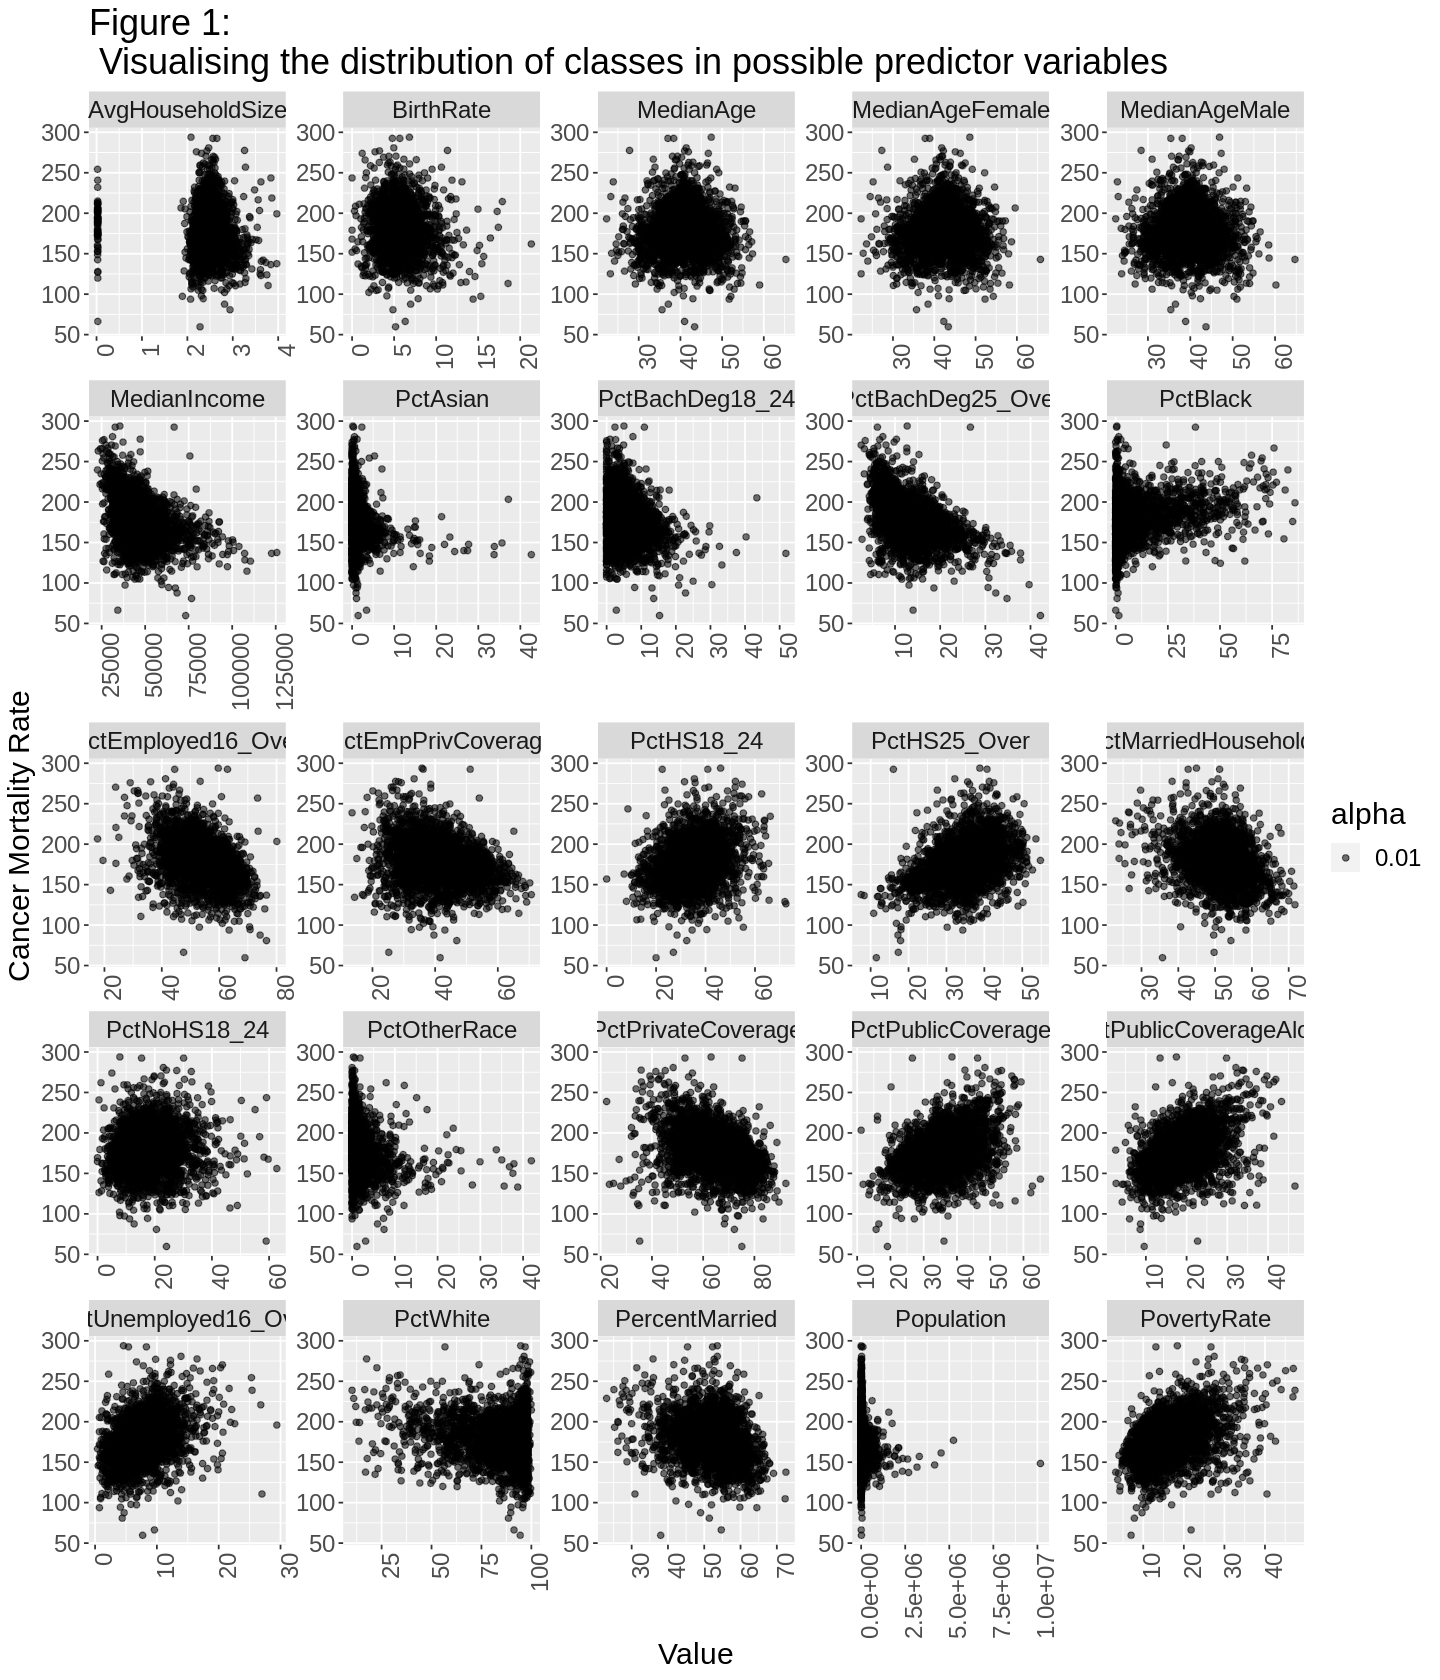

In [9]:
options(repr.plot.width = 12, repr.plot.height = 14)
paired_plot <- cancer_clean |>
    gather(key = "Predictor", value = "Value", -CancerMortRate) |>
    ggplot(aes(x = Value, y = CancerMortRate)) + #colouring the data points by the UNS column (which conatins the classes to be predicted)
    geom_point(aes(alpha = 0.01)) +
    ylab("Cancer Mortality Rate") +
    facet_wrap(~Predictor, scales = "free") +
    ggtitle("Figure 1: \n Visualising the distribution of classes in possible predictor variables") +
    theme(text = element_text(size = 18)) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) # adjusting the x-axis labels so they don't overlap wiht each other and are clearly visible

paired_plot

Looking at the last row of the panel above, we see how different predictors relate to the mortality rate of cancer patients.



### Linear Regression Model

We now form our linear regression model usine the predictors: PctBachDeg25_Over, PctHS25_Over, PovertyRate, PctMarriedHouseholds, PctUnemployed16_Over, PctOtherRace, PctEmpPrivCoverage, PctPublicCoverageAlone.
                   

In [10]:
lm_spec <- linear_reg() |>
  set_engine("lm") |> #selecting linear regression
  set_mode("regression")

#making our recipe using the predictor we found by performing regsubsets()
lm_recipe_1 <- recipe(CancerMortRate ~ PctBachDeg25_Over, 
                   data = cancer_training) 

#making our recipe using the 2 predictors we found by performing regsubsets()
lm_recipe_2 <- recipe(CancerMortRate ~ PctHS25_Over + PovertyRate, 
                   data = cancer_training) #making our recipe using the predictors we found by performing regsubsets()

#making our recipe using the 3 predictors we found by performing regsubsets()
lm_recipe_3 <- recipe(CancerMortRate ~ PctHS25_Over + PctMarriedHouseholds + PctUnemployed16_Over, 
                   data = cancer_training) #making our recipe using the predictors we found by performing regsubsets()

#making our recipe using the 4 predictors we found by performing regsubsets()
lm_recipe_4 <- recipe(CancerMortRate ~ PctOtherRace + PctMarriedHouseholds + PctUnemployed16_Over + PctBachDeg25_Over, 
                   data = cancer_training) #making our recipe using the predictors we found by performing regsubsets()

#making our recipe using the 5 predictors we found by performing regsubsets()
lm_recipe_5 <- recipe(CancerMortRate ~ PctPublicCoverageAlone + PctOtherRace + PctMarriedHouseholds + PctEmpPrivCoverage + PctBachDeg25_Over, 
                   data = cancer_training) #making our recipe using the predictors we found by performing regsubsets()

lm_fit_1 <- workflow() |>
  add_recipe(lm_recipe_1) |>
  add_model(lm_spec) |>
  fit(data = cancer_training)

lm_fit_2 <- workflow() |>
  add_recipe(lm_recipe_2) |>
  add_model(lm_spec) |>
  fit(data = cancer_training)

lm_fit_3 <- workflow() |>
  add_recipe(lm_recipe_3) |>
  add_model(lm_spec) |>
  fit(data = cancer_training)

lm_fit_4 <- workflow() |>
  add_recipe(lm_recipe_4) |>
  add_model(lm_spec) |>
  fit(data = cancer_training)

lm_fit_5 <- workflow() |>
  add_recipe(lm_recipe_5) |>
  add_model(lm_spec) |>
  fit(data = cancer_training)

#testing the accuracy of our model
lm_test_results_1 <- lm_fit_1 |>
    predict(cancer_training) |>
    bind_cols(cancer_training) |>
    metrics(truth = CancerMortRate, estimate = .pred) |>
    filter(.metric == "rmse") |>
    select(.estimate) |>
    pull()
    

lm_test_results_2 <- lm_fit_2 |>
    predict(cancer_training) |>
    bind_cols(cancer_training) |>
    metrics(truth = CancerMortRate, estimate = .pred) |>
    filter(.metric == "rmse") |>
    select(.estimate) |>
    pull()

lm_test_results_3 <- lm_fit_3 |>
    predict(cancer_training) |>
    bind_cols(cancer_training) |>
    metrics(truth = CancerMortRate, estimate = .pred) |>
    filter(.metric == "rmse") |>
    select(.estimate) |>
    pull()

lm_test_results_4 <- lm_fit_4 |>
  predict(cancer_training) |>
  bind_cols(cancer_training) |>
  metrics(truth = CancerMortRate, estimate = .pred) |>
    filter(.metric == "rmse") |>
    select(.estimate) |>
    pull()

lm_test_results_5 <- lm_fit_5 |>
  predict(cancer_training) |>
  bind_cols(cancer_training) |>
  metrics(truth = CancerMortRate, estimate = .pred) |>
    filter(.metric == "rmse") |>
    select(.estimate) |>
    pull()

In [11]:
lm_test_results_1

[1] 24.27868

In [12]:
lm_test_results_2

[1] 23.29129

In [13]:
lm_test_results_3

[1] 22.91852

In [14]:
lm_test_results_4

[1] 22.70062

In [15]:
lm_test_results_5

[1] 22.39484

### KNN Regression Model

In [16]:
knn_recipe_1 <- lm_recipe_1 |> #making recipe with our predictor variables
                        step_scale(all_predictors()) |> # scaling all predictors
                        step_center(all_predictors()) # centering all predictors

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("regression")

# create a 5-fold cross-validation object
cancer_vfold <- vfold_cv(cancer_training, v = 5, strata = CancerMortRate)

gridvals <- tibble(neighbors = seq(from = 1, to = 200, by = 5))

acc_1 <- workflow() |>
    add_recipe(knn_recipe_1) |>
    add_model(knn_spec) |>
    tune_grid(resamples = cancer_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

min_mean <- acc_1 |>
    filter(mean == min(mean)) #finding lowest mean to get the most accurate rmspe
min_mean

options(repr.plot.width = 7, repr.plot.height = 7)

plot_1 <- ggplot(acc_1, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line()+
    labs(x = "Neighbors when using 1 predictor",
         y = "RMSPE")+
    theme(text = element_text(size = 12))

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
111,rmse,standard,24.20753,5,0.3545183,Preprocessor1_Model23


#### Table 3: Least RMSPE for KNN regression with one predictor

In [17]:
knn_recipe_2 <- lm_recipe_2 |> #making recipe with our predictor variables
                        step_scale(all_predictors()) |> # scaling all predictors
                        step_center(all_predictors()) # centering all predictors

acc_2 <- workflow() |>
    add_recipe(knn_recipe_2) |>
    add_model(knn_spec) |>
    tune_grid(resamples = cancer_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

min_mean <- acc_2 |>
    filter(mean == min(mean)) #finding lowest mean to get the most accurate rmspe
min_mean

options(repr.plot.width = 7, repr.plot.height = 7)

plot_2 <- ggplot(acc_2, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line()+
    labs(x = "Neighbors when using 2 predictors",
         y = "RMSPE")+
    theme(text = element_text(size = 12))

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
46,rmse,standard,23.12093,5,0.3675245,Preprocessor1_Model10


#### Table 4: Least RMSPE for KNN regression with two predictors

In [18]:
knn_recipe_3 <- lm_recipe_3 |> #making recipe with our predictor variables
                        step_scale(all_predictors()) |> # scaling all predictors
                        step_center(all_predictors()) # centering all predictors

acc_3 <- workflow() |>
    add_recipe(knn_recipe_3) |>
    add_model(knn_spec) |>
    tune_grid(resamples = cancer_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

min_mean <- acc_3 |>
    filter(mean == min(mean)) #finding lowest mean to get the most accurate rmspe
min_mean

options(repr.plot.width = 7, repr.plot.height = 7)

plot_3 <- ggplot(acc_3, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line()+
    labs(x = "Neighbors when using 3 predictors",
         y = "RMSPE")+
    theme(text = element_text(size = 12))

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
41,rmse,standard,22.80953,5,0.4634875,Preprocessor1_Model09


#### Table 5: Least RMSPE for KNN regression with three predictors

In [19]:
knn_recipe_4 <- lm_recipe_4 |> #making recipe with our predictor variables
                        step_scale(all_predictors()) |> # scaling all predictors
                        step_center(all_predictors()) # centering all predictors

acc_4 <- workflow() |>
    add_recipe(knn_recipe_4) |>
    add_model(knn_spec) |>
    tune_grid(resamples = cancer_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

min_mean <- acc_4 |>
    filter(mean == min(mean)) #finding lowest mean to get the most accurate rmspe
min_mean

options(repr.plot.width = 7, repr.plot.height = 7)

plot_4 <- ggplot(acc_4, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line()+
    labs(x = "Neighbors when using 4 predictors",
         y = "RMSPE")+
    theme(text = element_text(size = 12))

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
36,rmse,standard,22.50341,5,0.3530156,Preprocessor1_Model08


#### Table 6: Least RMSPE for KNN regression with four predictors

In [20]:
knn_recipe_5 <- lm_recipe_5 |> #making recipe with our predictor variables
                        step_scale(all_predictors()) |> # scaling all predictors
                        step_center(all_predictors()) # centering all predictors

acc_5 <- workflow() |>
    add_recipe(knn_recipe_5) |>
    add_model(knn_spec) |>
    tune_grid(resamples = cancer_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

min_mean <- acc_5 |>
    filter(mean == min(mean)) #finding lowest mean to get the most accurate rmspe
min_mean

options(repr.plot.width = 7, repr.plot.height = 7)

plot_5 <- ggplot(acc_5, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line()+
    labs(x = "Neighbors when using 5 predictors",
         y = "RMSPE")+
    theme(text = element_text(size = 12))



neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
31,rmse,standard,22.3928,5,0.375454,Preprocessor1_Model07


#### Table 7: Least RMSPE for KNN regression with five predictors

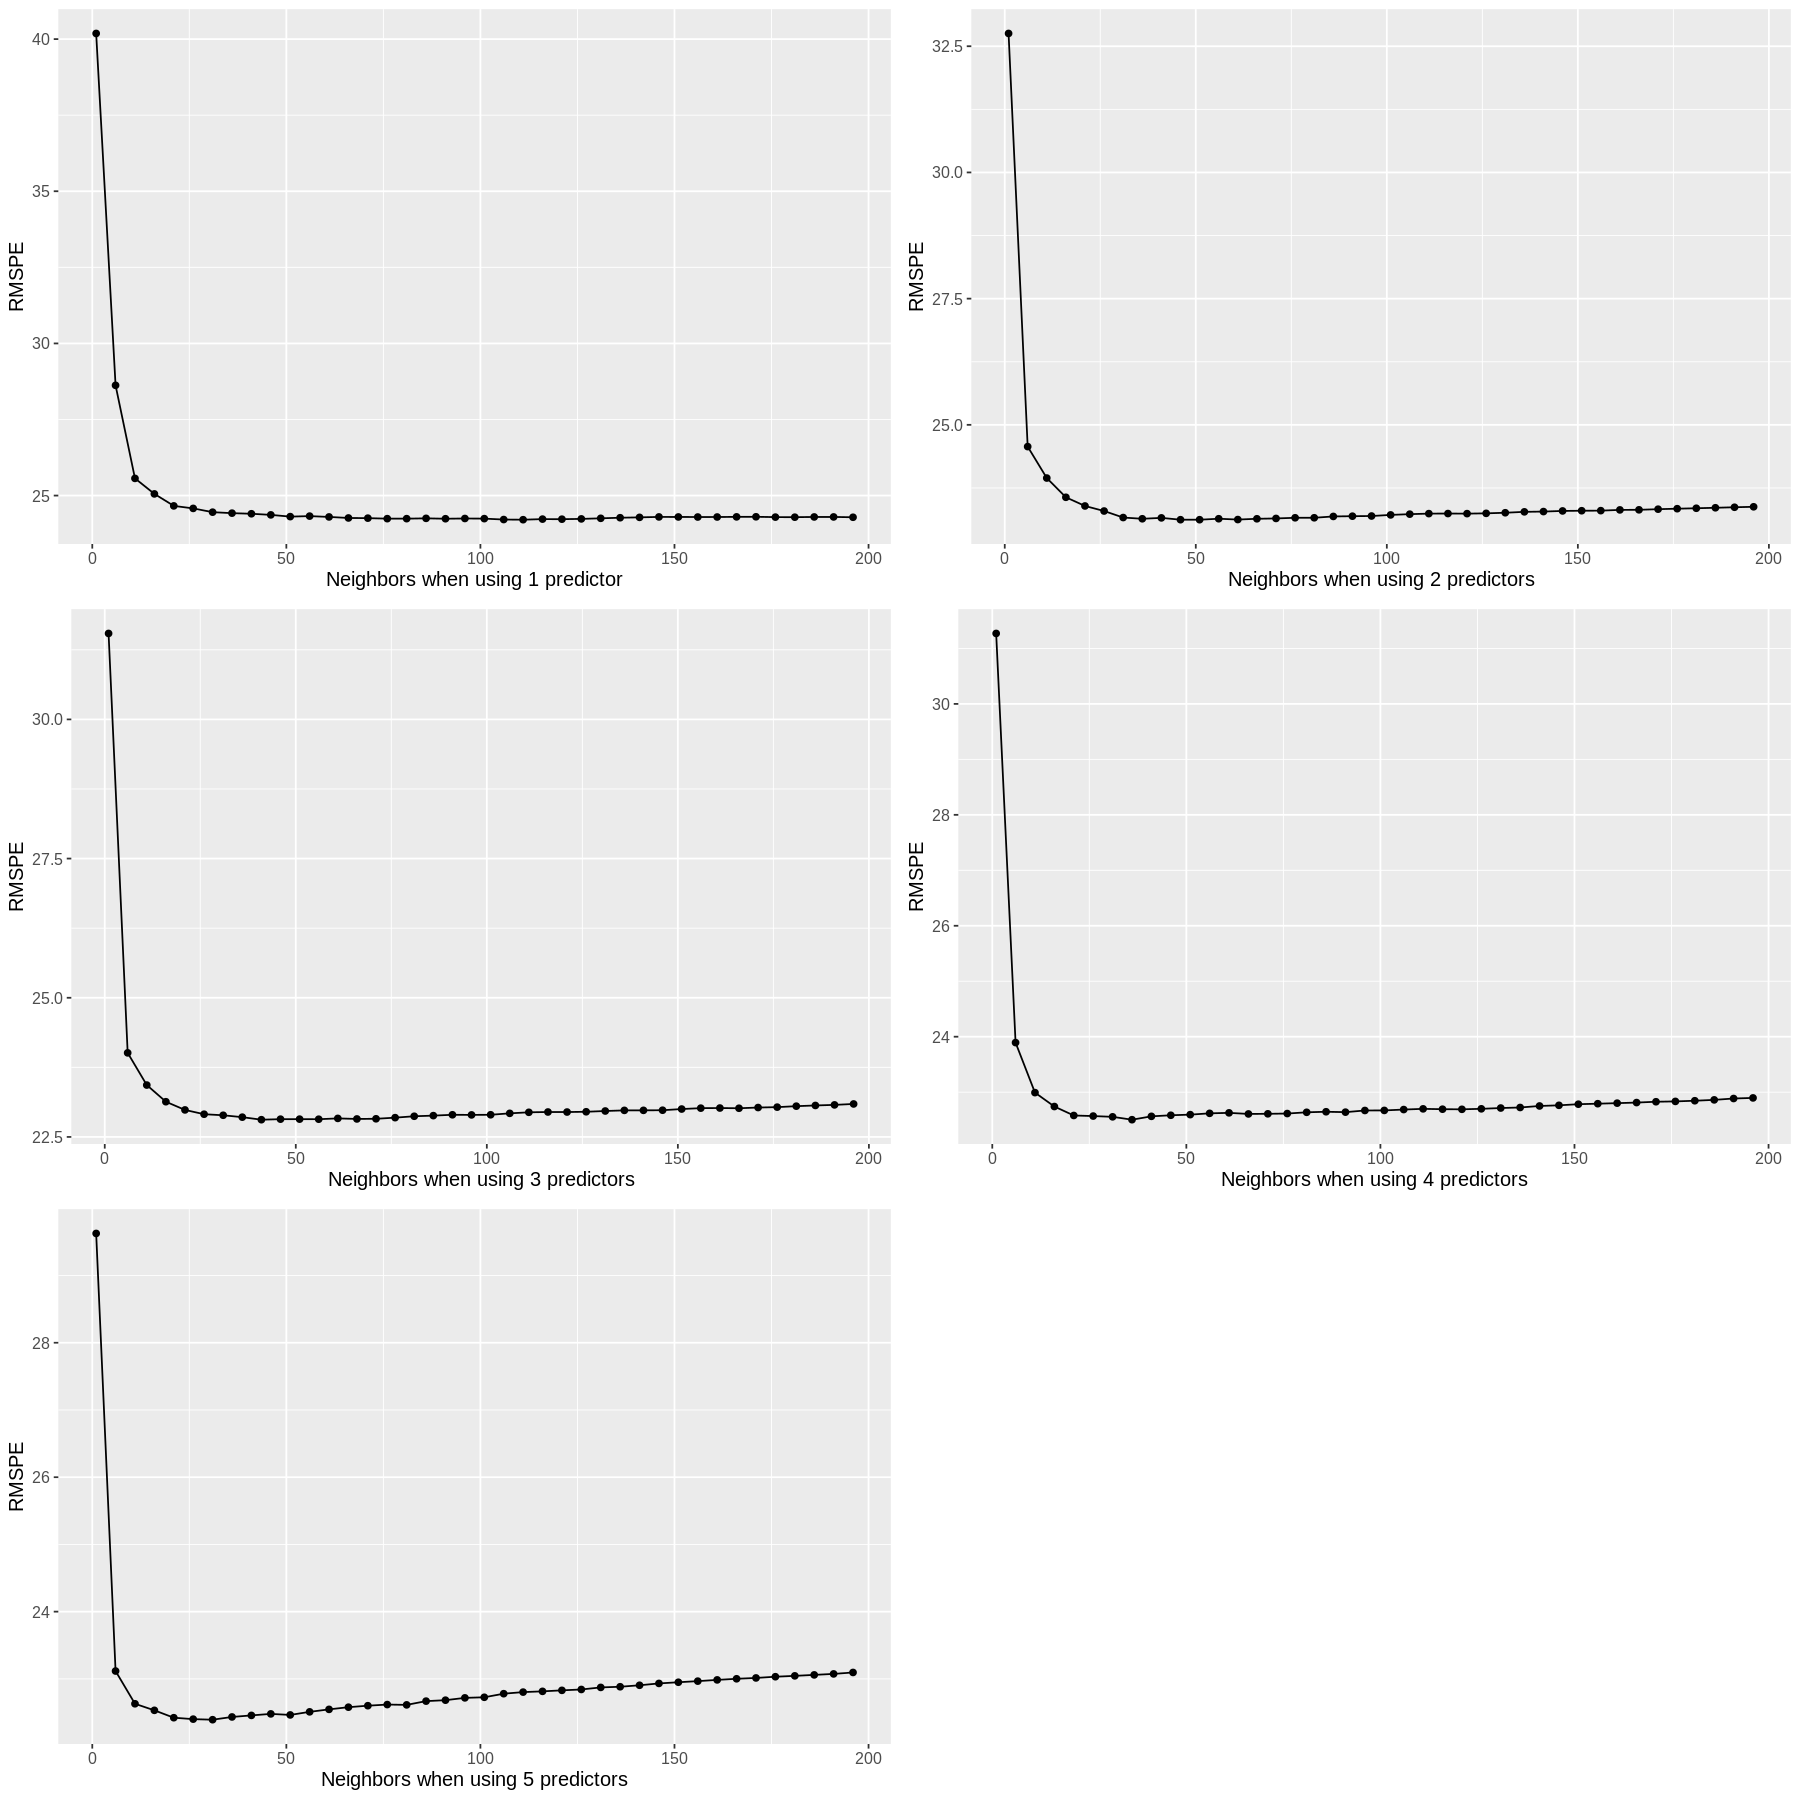

In [21]:
#visualizing all our plots 
options(repr.plot.width = 15, repr.plot.height = 15)
plot_grid(plot_1, plot_2, plot_3, plot_4, plot_5, ncol = 2)

#### Figure 2: Visualization of RMSPE vs Number of neighbors for all numbers of predictors

In [22]:
knn_spec_best <- nearest_neighbor(weight_func = "rectangular", neighbors = 31) |>
    set_engine("kknn") |>
    set_mode("regression")

knn_fit_best <- workflow() |>
    add_recipe(knn_recipe_5) |>
    add_model(knn_spec_best) |>
    fit(data = cancer_training)

predictions <- knn_fit_best |>
    predict(cancer_testing) |>
    bind_cols(cancer_testing)

metrics_cancer <- metrics(predictions, truth = CancerMortRate, estimate = .pred) |>
    filter(.metric == "rmse")
metrics_cancer

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,20.67824


#### Table 8: RMSPE value for KNN regression with five predictors and neighbors = 31

`geom_smooth()` using formula 'y ~ x'



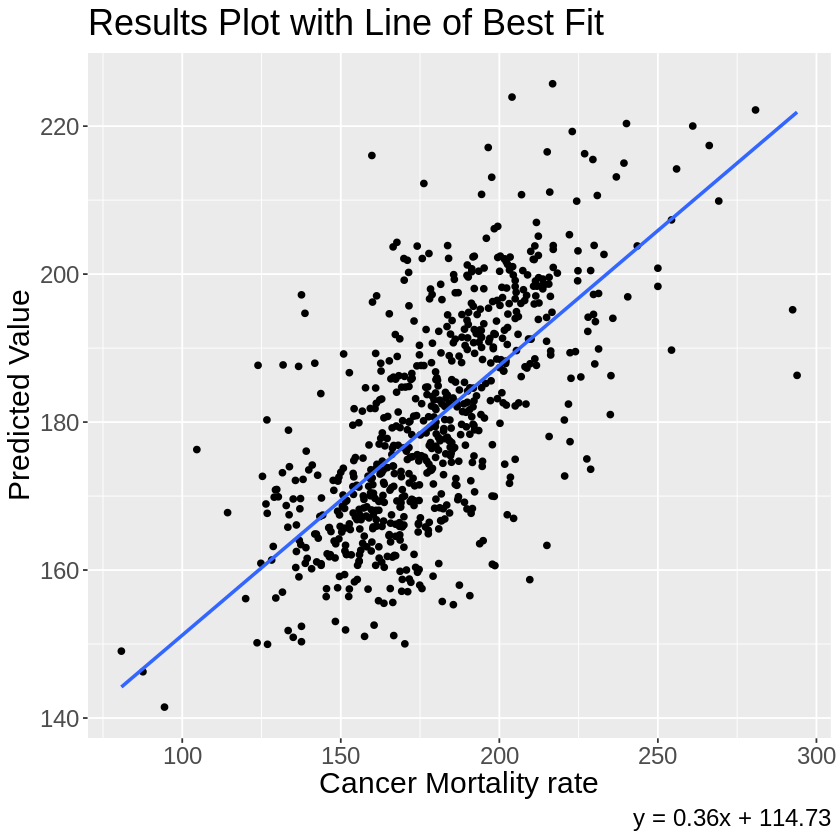

In [24]:
options(repr.plot.width = 7, repr.plot.height = 7)

results_plot <- ggplot(predictions, aes(x = CancerMortRate, y = .pred)) +
    geom_point() +
    geom_smooth(method = lm, se = FALSE)

# Fit linear regression
lm_model <- lm(.pred ~ CancerMortRate, data = predictions)

# Extract regression coefficients
intercept <- coef(lm_model)[1]
slope <- coef(lm_model)[2]

# Create the equation for the line of best fit
equation <- paste0("y = ", round(slope, 2), "x + ", round(intercept, 2))

# Plot the scatter plot with the line of best fit
results_plot <- ggplot(predictions, aes(x = CancerMortRate, y = .pred)) +
  geom_point() +
  geom_smooth(method = lm, se = FALSE) +
  labs(x = "Cancer Mortality rate", y = "Predicted Value",
       title = "Results Plot with Line of Best Fit",
       caption = equation) +
  theme(text = element_text(size = 18))
results_plot


#### Figure 3: Line of best fit on the regression model to compare true value and predicted value

### Discussion


As a result of our exploratory data analysis, we determined that many variables in our data frame were complete with many NA values, including the columns denoting the percent of residents with some college attained between teh ages of 18-24 and the percent of residents with only private health coverage. These columns were removed from the analysis. When plotting potential predictors with our target variable, we noticed some variables contained data that seemed likely unreflective of its true population.

We were initially expecting that age and income would be the most predominant predictors for our model. However, after using regsubsets to find the best subset selection, we were surprised to see variables such as race, edication, marital status, and health coverage were likely better at fitting our data.

After the exploratory data analysis, we started by identifying the model that best fit our training data. We analyzed the RMSE of 5 linear regression models and 5 k-nearest neighbour (KNN) regression models. Each linear and KNN model analyzed a different number of predictors, ranging one predictor to five predictors. The KNN models were tuned to find their best k-value with a 5-fold cross-validation and the models performed the best with 111, 46, 41, 36, and 31 (sorted from one predictor to five predictors). 

The linear regression models resulted in RMSEs of 24.28, 23.29, 22.92, 22.70, and 22.39 and the KNN models resulted in RMSEs of 24.21, 23.12, 22.81, 22.50, and 22.39. We went forward with the KNN model with 5 predictors since it resulted in the smallest RMSE of 22.39. The 5-predictor KNN model was used to predict the testing data’s cancer mortality rate values and the result was an RMSPE value of 20.69. To better interpret this RMSPE value, we graphed our predicted values against the true values of cancer mortality rates from the testing data and created a line of best-fit. Ideally the line of best-fit should be the equation $y = x$, signifying that the model’s predictions generally equate the true values of the testing data. Our line of best-fit’s equation was $y = 0.36x + 114.73$.

Our findings can affirm a greater need for healthcare access for populations with less education and healthcare coverage. The findings also highlight the potential importance of support systems such as spouses for patients undergoing cancer. The results of this study could lead to other research questions investigating the trends between demographic data and other illnesses, such as heart disease, diabetes, and obesity. Our findings could also help in making decisions about distribution of healthcare infrastructure and facilities according to more vulnerable demographics.

Our research could inspire several new questions. For example, would the same predictors apply to different populations? Most notably, would the same predictors be useful in Canadian populations? Additionally, how do these predictors interact with other demographic data that was unavailable in our dataset?

### Sources cited
1. Albano, J. D., Ward, E., Jemal, A., Anderson, R., Cokkinides, V. E., Murray, T., Henley, J., Liff, J., & Thun, M. J. (2007). Cancer mortality in the United States by education level and race. JNCI: Journal of the National Cancer Institute, 99(18), 1384–1394. https://doi.org/10.1093/jnci/djm127 

2. Barone, A., & Murry, C. (2022, May 28). Residual Sum of Squares (RSS): What It Is, How to Calculate It. Investopedia. Retrieved June 22, 2023, from https://www.investopedia.com/terms/r/residual-sum-of-squares.asp
3. Gerdtham, U.-G., & Johannesson, M. (2003). A note on the effect of unemployment on mortality. Journal of Health Economics, 22(3), 505–518. https://doi.org/10.1016/s0167-6296(03)00004-3 

4. Nelles, J. L., Joseph, S. A., & Konety, B. R. (2009). The impact of marriage on bladder cancer mortality. Urologic Oncology: Seminars and Original Investigations, 27(3), 263–267. https://doi.org/10.1016/j.urolonc.2008.04.016 

5. Rippner, N. (2016). OLS Regression Challenge. data.world. https://data.world/nrippner/ols-regression-challenge

6. Ruiz, E. F., Torres-Roman, J. S., Servan, S. A., Martinez-Herrera, J. F., Arce-Huamani, M. A., Carioli, G., & La Vecchia, C. (2019). Trends and geographic pattern of stomach cancer mortality in peru. Cancer Epidemiology, 58, 193-198. https://doi.org/10.1016/j.canep.2018.10.018
7. Vaccarella, S., Georges, D., Bray, F., Ginsburg, O., Charvat, H., Martikainen, P., Brønnum-Hansen, H., Deboosere, P., Bopp, M., Leinsalu, M., Artnik, B., Lorenzoni, V., De Vries, E., Marmot, M., Vineis, P., Mackenbach, J., & Nusselder, W. (2023). Socioeconomic inequalities in cancer mortality between and within countries in Europe: A population-based study. The Lancet Regional Health - Europe, 25, 100551. https://doi.org/10.1016/j.lanepe.2022.100551
